# CIDS-Sim with Non-IID data

Federated Learning involves collaboration among multiple clients to learn from decentralized data. In the context of CIDS, each client acts as a detector unit distributed across various networks, while the central server, responsible for aggregating the models, functions as the correlation unit. This research employs a non-IID (Non-Independent and Identically Distributed) data setting to distribute data across different clients. The Federated Averaging (FedAvg) algorithm is used to aggregate models from multiple clients.

## Dataset

This simulator will use a Coordinated Attack dataset from [here](https://data.mendeley.com/datasets/28tmfg3rzb/2).

## Other Information

The simulator will run binary classification, so the traffic will labeled as normal (0) or anomaly (1)

---

First, import libraries

---

In [1]:
import numpy as np
import pandas as pd
import time
import psutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import Recall, Precision

from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

2024-11-28 09:35:45.321190: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 09:35:45.325275: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 09:35:45.335734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 09:35:45.352129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 09:35:45.356913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 09:35:45.370420: I tensorflow/core/platform/cpu_feature_gu

---

Load Coordinated Attack dataset. We are using ".parquet" file for faster reading data.

Use `CoAt_NF-UQ-NIDS-V2.parquet` for a dataset with the NF feature for the Non-IID scenario.

---

In [2]:
# Use this to read dataset using parquet file (default)
df = pd.read_parquet('./dataset/CoAt_NF-UQ-NIDS-V2.parquet', engine='pyarrow')

---

View the dataset information

---

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43636597 entries, 2 to 62672010
Data columns (total 43 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   L4_SRC_PORT                  int16  
 1   L4_DST_PORT                  int16  
 2   PROTOCOL                     int16  
 3   L7_PROTO                     float32
 4   IN_BYTES                     int32  
 5   IN_PKTS                      int32  
 6   OUT_BYTES                    int32  
 7   OUT_PKTS                     int32  
 8   TCP_FLAGS                    int16  
 9   CLIENT_TCP_FLAGS             int16  
 10  SERVER_TCP_FLAGS             int16  
 11  FLOW_DURATION_MILLISECONDS   int32  
 12  DURATION_IN                  int32  
 13  DURATION_OUT                 int32  
 14  MIN_TTL                      int16  
 15  MAX_TTL                      int16  
 16  LONGEST_FLOW_PKT             int32  
 17  SHORTEST_FLOW_PKT            int16  
 18  MIN_IP_PKT_LEN               int16  
 19  MAX

---

Choose a binary label, so we drop the multi-class label

---

In [4]:
df = df.drop(columns=['Label'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43636597 entries, 2 to 62672010
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   L4_SRC_PORT                  int16  
 1   L4_DST_PORT                  int16  
 2   PROTOCOL                     int16  
 3   L7_PROTO                     float32
 4   IN_BYTES                     int32  
 5   IN_PKTS                      int32  
 6   OUT_BYTES                    int32  
 7   OUT_PKTS                     int32  
 8   TCP_FLAGS                    int16  
 9   CLIENT_TCP_FLAGS             int16  
 10  SERVER_TCP_FLAGS             int16  
 11  FLOW_DURATION_MILLISECONDS   int32  
 12  DURATION_IN                  int32  
 13  DURATION_OUT                 int32  
 14  MIN_TTL                      int16  
 15  MAX_TTL                      int16  
 16  LONGEST_FLOW_PKT             int32  
 17  SHORTEST_FLOW_PKT            int16  
 18  MIN_IP_PKT_LEN               int16  
 19  MAX

---

View normal (0) and anomaly (1) traffic distribution

---

In [5]:
df['Attack'].value_counts()

Attack
1    22892774
0    20743823
Name: count, dtype: int64

---

X and y are used to represent the input features and the corresponding target labels, respectively.

---

In [6]:
X_df = df.drop(columns=['Attack'])
y_df = df['Attack']

---

Scaling data to ensures that features have values in the same range

---

In [7]:
# Use this scaler for NF dataset
scaler = QuantileTransformer(output_distribution='normal')

In [8]:
X_df_scl = scaler.fit_transform(X_df)

---

This Python function, `load_data(client_id)`, is designed to load a portion of data for a specific client in a Federated Learning setting where non-IID data is distributed among different clients. That process is designed to divide a large dataset into smaller portions for different clients.

Please change `fraction` variable if you want to change the data portion that will distribute to each client.

---

In [9]:
def load_data(client_id):
    
    # Create non-IID splits based on client_id
    np.random.seed(client_id)
    indices = np.arange(len(X_df_scl))
    np.random.shuffle(indices)

    # Choose a fraction of the data for this client
    fraction = 0.2
    client_data_size = int(fraction * len(X_df_scl))
    client_indices = indices[:client_data_size]

    X_client = X_df_scl[client_indices]
    y_client = y_df.iloc[client_indices]

    return X_client, y_client

---

The `create_model()` function defines a simple deep neural network model using Keras.
You can change the **number of neurons** in each **Dense layer**.
You can also experiment by changing the **Activation function, Loss function, and optimizer** from the deep learning model.

---

In [10]:
# Define a simple deep neural network model
def create_model(input_shape):
    model = keras.Sequential([
        layers.Dense(20, activation='relu', input_shape=(input_shape,)),
        layers.Dense(10, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(3, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy', Recall(), Precision()])
    return model

---

Calculate model size to measure the overhead in communication

---

In [11]:
def calculate_model_size(model):
    """Calculate the size of a model (in bytes) by summing the number of parameters."""
    total_params = np.sum([np.prod(weights.shape) for weights in model.get_weights()])
    size_in_bytes = total_params * 4  # Assuming 32-bit float (4 bytes per parameter)
    return size_in_bytes

---

The `cids_federated_training()` function implements the **training process for a Collaborative Intrusion Detection System (CIDS) using Federated Learning**. The goal is to train a global model based on the local training of models across multiple distributed nodes, without sharing raw data. 

This function performs federated learning for intrusion detection across `num_nodes` (clients or devices) over `num_rounds` (iterations of federated learning). You can experiment by changing `num_nodes` and `num_rounds` from this function.

---

In [12]:
# CIDS with federated learning training process

# change num_nodes and num_rounds for your simulation scenario

def cids_federated_training(num_nodes=5, num_rounds=5): 
    input_shape_glob = X_df_scl.shape[1]
    global_model = create_model(input_shape=input_shape_glob)
    global_weights = global_model.get_weights()

    global_pred_times = []

    # Calculate model size (bytes per round of communication)
    model_size = calculate_model_size(global_model)
    print(f"Model size: {model_size / 1e6:.2f} MB")

    communication_overhead = 0

    #Global model performance evaluation
    global_accuracies = []
    global_precisions = []
    global_recalls = []
    global_f1s = []

    # Variable for global training and prediction time
    total_training_times = []
    total_prediction_times = []

    # Variable for global training CPU and Memory usage
    cpu_usages = []
    memory_usages = []

    # Variable for global variance in performance across nodes
    accuracy_variances = []
    precision_variances = []
    recall_variances = []
    f1_variances = []

    # Variable for global standard deviation of performance
    accuracy_stds = []
    precision_stds = []
    recall_stds = []
    f1_stds = []

    # Initial evaluation
    X_test, Y_test = load_data(num_nodes+1)

    # Training rounds
    for round in range(num_rounds):
        local_weights = []
        local_training_times = []
        local_prediction_times = []

        #Local model performance evaluation
        local_accuracies = []
        local_precisions = []
        local_recalls = []
        local_f1s = []

        # Local CPU and Memory usage
        round_cpu_usage = []
        round_memory_usage = []

        print(f"\n------------------------------------------------------------\n")
        print(f"Training Round {round + 1}\n")

        for node in range(num_nodes):
            X, Y = load_data(node)
                    
            X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
            
            input_shape = X_train.shape[1]

            model = create_model(input_shape=input_shape)
            model.set_weights(global_weights)

            # Measure CPU and memory utilization during training
            cpu_before = psutil.cpu_percent(interval=None)
            memory_before = psutil.virtual_memory().percent

            # Measure local training time
            start_train_time = time.time()
            #local training time
            model.fit(X_train, Y_train, epochs=10, batch_size=1000, verbose=0)
            end_train_time = time.time()

            cpu_after = psutil.cpu_percent(interval=None)
            memory_after = psutil.virtual_memory().percent

            local_training_time = end_train_time - start_train_time
            local_training_times.append(local_training_time)

            cpu_usage = cpu_after - cpu_before
            memory_usage = memory_after - memory_before

            print(f"Node {node + 1}: Training Time {local_training_time:.4f} seconds")
            print(f"Node {node + 1}: CPU Usage {cpu_usage:.2f}% - Memory Usage {memory_usage:.2f}%")

            # Measure local resource consumption
            round_cpu_usage.append(cpu_usage)
            round_memory_usage.append(memory_usage)

            # Measure local prediction time
            start_pred_time = time.time()
            # Validation
            loss, accuracy, precision, recall = model.evaluate(X_val, Y_val, verbose=0)
            end_pred_time = time.time()

            local_prediction_time = end_pred_time - start_pred_time
            local_prediction_times.append(local_prediction_time)

            print(f"Node {node + 1}: Prediction Time {local_prediction_time:.4f} seconds")
            
            f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
            print(f"Node {node + 1}: Accuracy {accuracy:.4f} - Precision {precision:.4f} - Recall {recall:.4f} - F1-Score {f1_score:.4f}\n")

            #Append local performance data
            local_accuracies.append(accuracy)
            local_precisions.append(precision)
            local_recalls.append(recall)
            local_f1s.append(f1_score)
            
            local_weights.append(model.get_weights())

            # Communication: Server receiving weights from each node
            communication_overhead += model_size

        # Measure server aggregation time
        start_aggregation_time = time.time()
        # Aggregate weights
        new_weights = [np.mean([weight[layer] for weight in local_weights], axis=0) for layer in range(len(global_weights))]
        end_aggregation_time = time.time()
        
        aggregation_time = end_aggregation_time - start_aggregation_time
        print(f"Aggregation Time round {round + 1}: {aggregation_time:.4f} seconds")
        
        global_weights = new_weights
        global_model.set_weights(global_weights)

        # Communication: Server sending updated weights to all nodes
        communication_overhead += num_nodes * model_size

        print(f"Total communication overhead after round {round + 1}: {communication_overhead / 1e6:.2f} MB")

        # Evaluate and measure the time
        start_glob_pred_time = time.time()
        loss, accuracy, precision, recall = model.evaluate(X_test, Y_test, verbose=0)
        end_glob_pred_time = time.time()

        global_pred_time = end_glob_pred_time - start_glob_pred_time
        global_pred_times.append(global_pred_time)

        print(f"\nGlobal Prediction Time Round {round + 1}: {global_pred_time:.4f}")

        # Evaluate global model accuracy
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
        global_accuracies.append(accuracy)
        global_precisions.append(precision)
        global_recalls.append(recall)
        global_f1s.append(f1_score)
        
        print(f"\nRound {round + 1}: Accuracy {accuracy:.4f} - Precision {precision:.4f} - Recall {recall:.4f} - F1-Score {f1_score:.4f}\n")

        # Cross-node Generalization Calculation
        accuracy_variance = np.var(local_accuracies)
        accuracy_variances.append(accuracy_variance)
        precision_variance = np.var(local_precisions)
        precision_variances.append(precision_variance)
        recall_variance = np.var(local_recalls)
        recall_variances.append(recall_variance)
        f1_variance = np.var(local_f1s)
        f1_variances.append(f1_variance)

        accuracy_std = np.std(local_accuracies)
        accuracy_stds.append(accuracy_std)
        precision_std = np.std(local_precisions)
        precision_stds.append(precision_std)
        recall_std = np.std(local_recalls)
        recall_stds.append(recall_std)
        f1_std = np.std(local_f1s)
        f1_stds.append(f1_std)

        print(f"Cross-node Generalization after Round {round + 1}:")
        print(f"Accuracy Variance: {accuracy_variance:.4f}, Accuracy Std: {accuracy_std:.4f}")
        print(f"Precision Variance: {precision_variance:.4f}, Precision Std: {precision_std:.4f}")
        print(f"Recall Variance: {recall_variance:.4f}, Recall Std: {recall_std:.4f}")
        print(f"F1-Score Variance: {f1_variance:.4f}, F1-Score Std: {f1_std:.4f}\n")

        # Calculate total training time for the round
        total_training_time = sum(local_training_times) + aggregation_time
        total_training_times.append(total_training_time)

        print(f"\nTotal Training Time Round {round + 1}: {total_training_time:.4f}")

        # Calculate total prediction time for the round
        total_prediction_time = sum(local_prediction_times)
        total_prediction_times.append(total_prediction_time)

        print(f"\nTotal Prediction Time Round {round + 1}: {total_prediction_time:.4f}")

        # Append round-level resource utilization
        cpu_usages.append(np.mean(round_cpu_usage))
        memory_usages.append(np.mean(round_memory_usage))

    return global_model, global_accuracies, global_precisions, global_recalls, global_f1s, communication_overhead, total_training_times, total_prediction_times, global_pred_times, cpu_usages, memory_usages, accuracy_variances, precision_variances, recall_variances, f1_variances, accuracy_stds, precision_stds, recall_stds, f1_stds

---

Run the simulation, then get the global model and perfromance metric in each round.

---

In [13]:
# Run CIDS simulator with Non-IID data from single dataset
print("Simulation for CIDS with Non-IID Data\n")
fl_model, fl_global_accuracies, fl_global_precisions, fl_global_recalls, fl_global_f1s, communication_overhead, total_training_times, total_prediction_times, global_pred_times, cpu_usages, memory_usages, accuracy_variances, precision_variances, recall_variances, f1_variances, accuracy_stds, precision_stds, recall_stds, f1_stds = cids_federated_training()

Simulation for CIDS with Non-IID Data

Model size: 0.00 MB


/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



------------------------------------------------------------

Training Round 1

Node 1: Training Time 74.0018 seconds
Node 1: CPU Usage 9.60% - Memory Usage 0.40%
Node 1: Prediction Time 32.1337 seconds
Node 1: Accuracy 0.9712 - Precision 0.9728 - Recall 0.9723 - F1-Score 0.9725

Node 2: Training Time 74.2419 seconds
Node 2: CPU Usage 1.90% - Memory Usage -0.60%
Node 2: Prediction Time 32.4320 seconds
Node 2: Accuracy 0.9723 - Precision 0.9787 - Recall 0.9688 - F1-Score 0.9737

Node 3: Training Time 74.5390 seconds
Node 3: CPU Usage 1.50% - Memory Usage -0.40%
Node 3: Prediction Time 33.4572 seconds
Node 3: Accuracy 0.9711 - Precision 0.9771 - Recall 0.9682 - F1-Score 0.9726

Node 4: Training Time 74.8264 seconds
Node 4: CPU Usage 1.80% - Memory Usage -0.30%
Node 4: Prediction Time 33.4586 seconds
Node 4: Accuracy 0.9714 - Precision 0.9741 - Recall 0.9716 - F1-Score 0.9728

Node 5: Training Time 74.9395 seconds
Node 5: CPU Usage 2.00% - Memory Usage -0.40%
Node 5: Prediction Time 32.7

In [14]:
print(f"\nFinal Communication Overhead: {communication_overhead / 1e6:.2f} MB")


Final Communication Overhead: 0.23 MB


---

Plot the performance metric in each round using graph

---

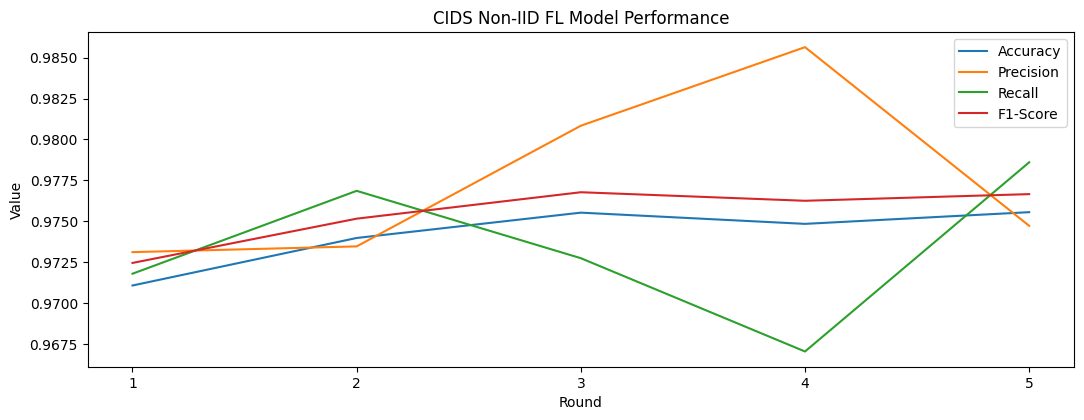

In [15]:
# Plotting model performance results
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds1 = np.arange(1, len(fl_global_accuracies) + 1)
plt.plot(rounds1, fl_global_accuracies, label='Accuracy')
plt.plot(rounds1, fl_global_precisions, label='Precision')
plt.plot(rounds1, fl_global_recalls, label='Recall')
plt.plot(rounds1, fl_global_f1s, label='F1-Score')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Non-IID FL Model Performance')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

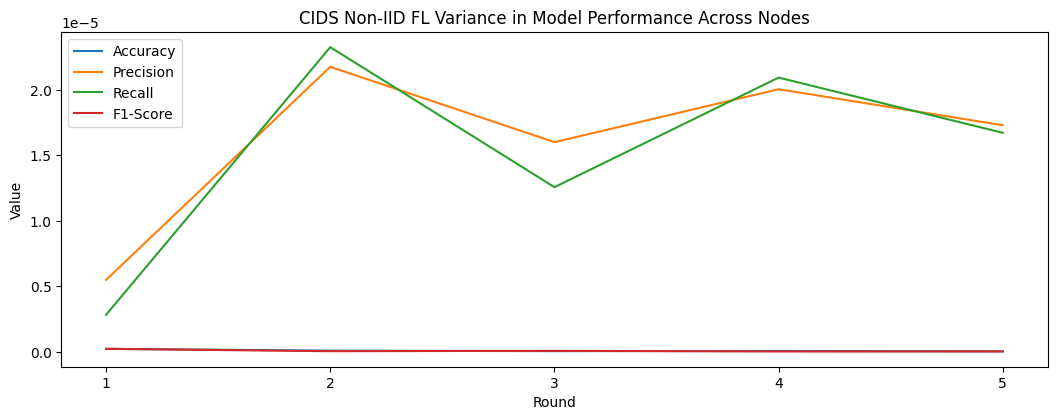

In [16]:
# Plotting model robustness and generalization results
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds2 = np.arange(1, len(accuracy_variances) + 1)
plt.plot(rounds2, accuracy_variances, label='Accuracy')
plt.plot(rounds2, precision_variances, label='Precision')
plt.plot(rounds2, recall_variances, label='Recall')
plt.plot(rounds2, f1_variances, label='F1-Score')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Non-IID FL Variance in Model Performance Across Nodes')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

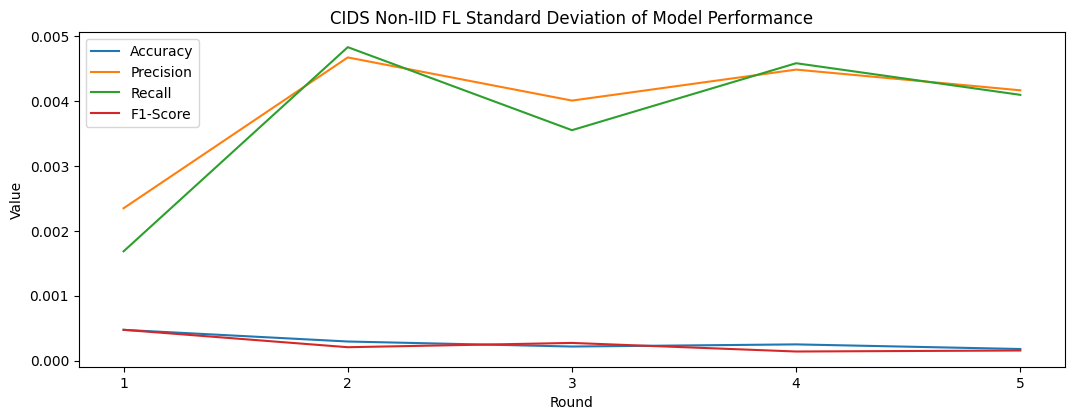

In [17]:
# Plotting model robustness and generalization results
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds3 = np.arange(1, len(accuracy_stds) + 1)
plt.plot(rounds3, accuracy_stds, label='Accuracy')
plt.plot(rounds3, precision_stds, label='Precision')
plt.plot(rounds3, recall_stds, label='Recall')
plt.plot(rounds3, f1_stds, label='F1-Score')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Non-IID FL Standard Deviation of Model Performance')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

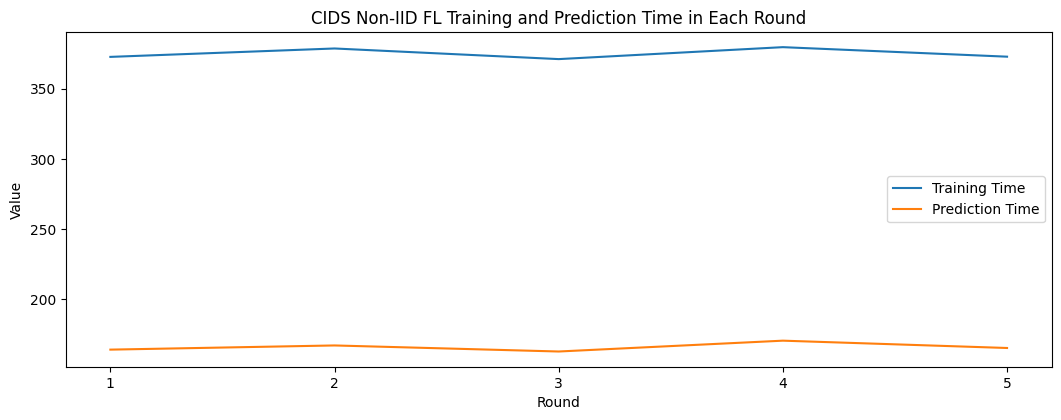

In [18]:
# Plotting training and prediction time
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds4 = np.arange(1, len(total_training_times) + 1)
plt.plot(rounds4, total_training_times, label='Training Time')
plt.plot(rounds4, total_prediction_times, label='Prediction Time')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Non-IID FL Training and Prediction Time in Each Round')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

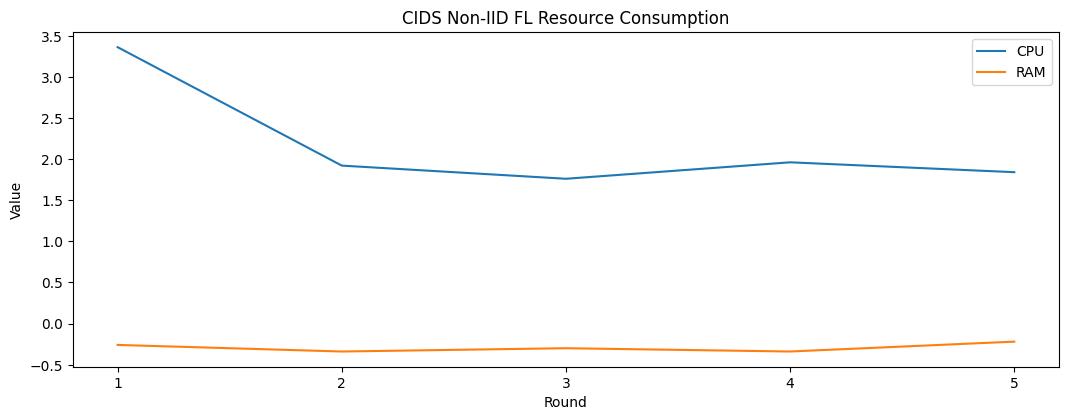

In [19]:
# Plotting resource consumption
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds5 = np.arange(1, len(cpu_usages) + 1)
plt.plot(rounds5, cpu_usages, label='CPU')
plt.plot(rounds5, memory_usages, label='RAM')
plt.xlabel('Round')
plt.ylabel('Value')
plt.title('CIDS Non-IID FL Resource Consumption')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

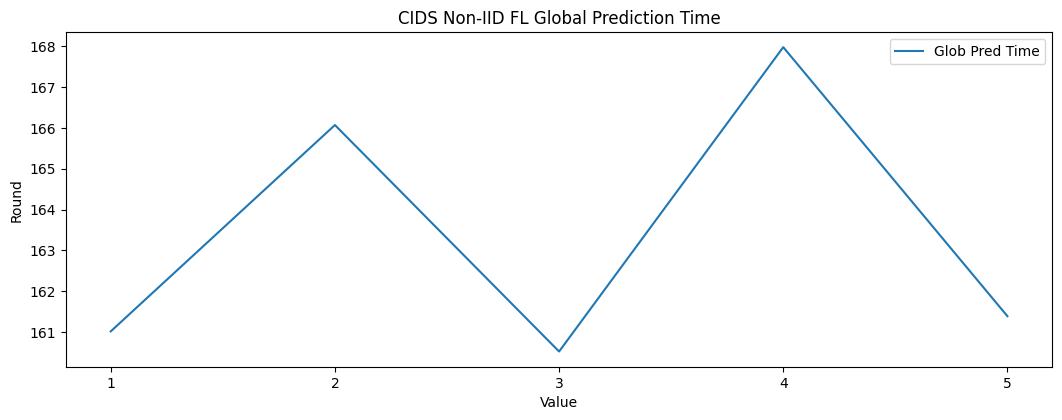

In [20]:
# Plotting global prediction time
plt.figure(figsize=(28, 20))

plt.subplot(4, 2, 1)
rounds6 = np.arange(1, len(global_pred_times) + 1)
plt.plot(rounds6, global_pred_times, label='Glob Pred Time')
plt.ylabel('Round')
plt.xlabel('Value')
plt.title('CIDS Non-IID FL Global Prediction Time')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()

In [21]:
# Number of rounds
rounds = list(range(1, len(fl_global_accuracies) + 1))

# Save global performance metrics with rounds
global_metrics_df = pd.DataFrame({
    "Round": rounds,
    "Global Accuracy": fl_global_accuracies,
    "Global Precision": fl_global_precisions,
    "Global Recall": fl_global_recalls,
    "Global F1-Score": fl_global_f1s,
    "Global Prediction Time": global_pred_times,
    "Total Training Times": total_training_times,
    "Total Prediction Times": total_prediction_times,
    "CPU Usage": cpu_usages,
    "Memory Usage": memory_usages,
    "Accuracy Variance": accuracy_variances,
    "Precision Variance": precision_variances,
    "Recall Variance": recall_variances,
    "F1 Variance": f1_variances,
    "Accuracy Std": accuracy_stds,
    "Precision Std": precision_stds,
    "Recall Std": recall_stds,
    "F1 Std": f1_stds
})

# Export global metrics to a CSV
global_metrics_df.to_csv("global_performance_metrics_FL_Non-IID_Binary.csv", index=False)

print("All metrics exported to CSV files successfully.")

All metrics exported to CSV files successfully.
